Автор: Косачев Дмитрий

Краткое содержание: Сравнение токенизаторов WordPunctTokenizer, Natasha, NLTK и классификаторов Logistic Regression, Naive Bayes, Decision Tree, Bagging, AdaBoost


In [1]:
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from natasha import Segmenter, NewsEmbedding, NewsMorphTagger, MorphVocab, Doc


In [2]:
# Загрузка данных
df = pd.read_excel("hackaton_result_dataset.xlsx")

texts_train = df['model_annotation'].values[:5000]
y_train = df['label'].values[:5000]
texts_test = df['model_annotation'].values[5000:]
y_test = df['label'].values[5000:]


In [3]:
# Определение токенизаторов
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def preprocess_default(text):
    tokenizer = WordPunctTokenizer()
    return ' '.join(tokenizer.tokenize(text.lower()))

def preprocess_natasha(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    tokens = [_.text for _ in doc.tokens]
    return ' '.join(tokens).lower()

def preprocess_nltk(text):
    return ' '.join(word_tokenize(text.lower()))


In [4]:
# Словарь токенизаторов
tokenizers = {
    'WordPunctTokenizer': preprocess_default,
    'Natasha': preprocess_natasha,
    'NLTK': preprocess_nltk
}


In [5]:
# Инициализация классификаторов
base_classifiers = {
    'Logistic Regression': LogisticRegression(penalty='l2'),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier()
}


In [6]:
# Обертки для классификаторов
ensemble_classifiers = {
    'Logistic Regression': LogisticRegression(penalty='l2'),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=0),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=0, algorithm='SAMME')
}


In [7]:
# Словарь для сохранения результатов
out_dict = {}


In [8]:
# Функция для визуализации и сохранения результатов
def visualize_results(out_dict):
    plt.figure(figsize=(12, 17))
    lines = []
    labels = []
    for key, value in out_dict.items():
        # График для тестовых данных
        line_test, = plt.plot(value['fpr'], value['tpr'], label=f'{key} Test AUC = {value["auc"]:.4f}')
        # График для тренировочных данных с тем же цветом, но пунктиром
        line_train, = plt.plot(value['fpr_train'], value['tpr_train'], '--', color=line_test.get_color(), label=f'{key} Train AUC = {value["auc_train"]:.4f}')
        # Сохранение линий и меток для отдельного построения легенд
        lines.append(line_train)
        labels.append(f'{key} Train AUC = {value["auc_train"]:.4f}')
        lines.append(line_test)
        labels.append(f'{key} Test AUC = {value["auc"]:.4f}')
        
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.title('ROC Curves for Different Models and Tokenizers')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()

    # Размещение легенды под графиком, отдельно для train и test
    train_lines = lines[::2]
    train_labels = labels[::2]
    test_lines = lines[1::2]
    test_labels = labels[1::2]

    first_legend = plt.legend(train_lines, train_labels, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, -0.1), ncol=1)
    plt.gca().add_artist(first_legend)
    plt.legend(test_lines, test_labels, fontsize='large', loc='upper center', bbox_to_anchor=(0.75, -0.1), ncol=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Уменьшение размеров графика, чтобы легенда поместилась

    plt.show()


In [9]:
for tokenizer_name, tokenizer_function in tokenizers.items():
    
    # Предварительная обработка текстов
    texts_train_preprocessed = [tokenizer_function(text) for text in texts_train]
    texts_test_preprocessed = [tokenizer_function(text) for text in texts_test]
    
    # Векторизация текстов
    vectorizer = TfidfVectorizer()
    vt_train = vectorizer.fit_transform(texts_train_preprocessed)
    vt_test = vectorizer.transform(texts_test_preprocessed)
    
    # Объединение классификаторов
    classifiers = {**base_classifiers, **ensemble_classifiers}
    
    # Цикл по классификаторам
    for classifier_name, classifier in classifiers.items():
        model_key = f'{tokenizer_name}_{classifier_name}'
        
        print(f'Tokenizer: {tokenizer_name}, Classifier: {classifier_name}')
        
        # Обучение и оценка модели
        classifier.fit(vt_train, y_train)
        proba_train = classifier.predict_proba(vt_train)[:, 1]
        proba_test = classifier.predict_proba(vt_test)[:, 1]
        fpr_train, tpr_train, _ = roc_curve(y_train, proba_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, proba_test)
        auc_train = roc_auc_score(y_train, proba_train)
        auc_test = roc_auc_score(y_test, proba_test)
        
        # Сохранение результатов
        out_dict[model_key] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': auc_test,
                               'fpr_train': fpr_train, 'tpr_train': tpr_train, 'auc_train': auc_train}


Tokenizer: WordPunctTokenizer, Classifier: Logistic Regression
Tokenizer: WordPunctTokenizer, Classifier: Naive Bayes
Tokenizer: WordPunctTokenizer, Classifier: Decision Tree
Tokenizer: WordPunctTokenizer, Classifier: Bagging
Tokenizer: WordPunctTokenizer, Classifier: AdaBoost
Tokenizer: Natasha, Classifier: Logistic Regression
Tokenizer: Natasha, Classifier: Naive Bayes
Tokenizer: Natasha, Classifier: Decision Tree
Tokenizer: Natasha, Classifier: Bagging
Tokenizer: Natasha, Classifier: AdaBoost
Tokenizer: NLTK, Classifier: Logistic Regression
Tokenizer: NLTK, Classifier: Naive Bayes
Tokenizer: NLTK, Classifier: Decision Tree
Tokenizer: NLTK, Classifier: Bagging
Tokenizer: NLTK, Classifier: AdaBoost


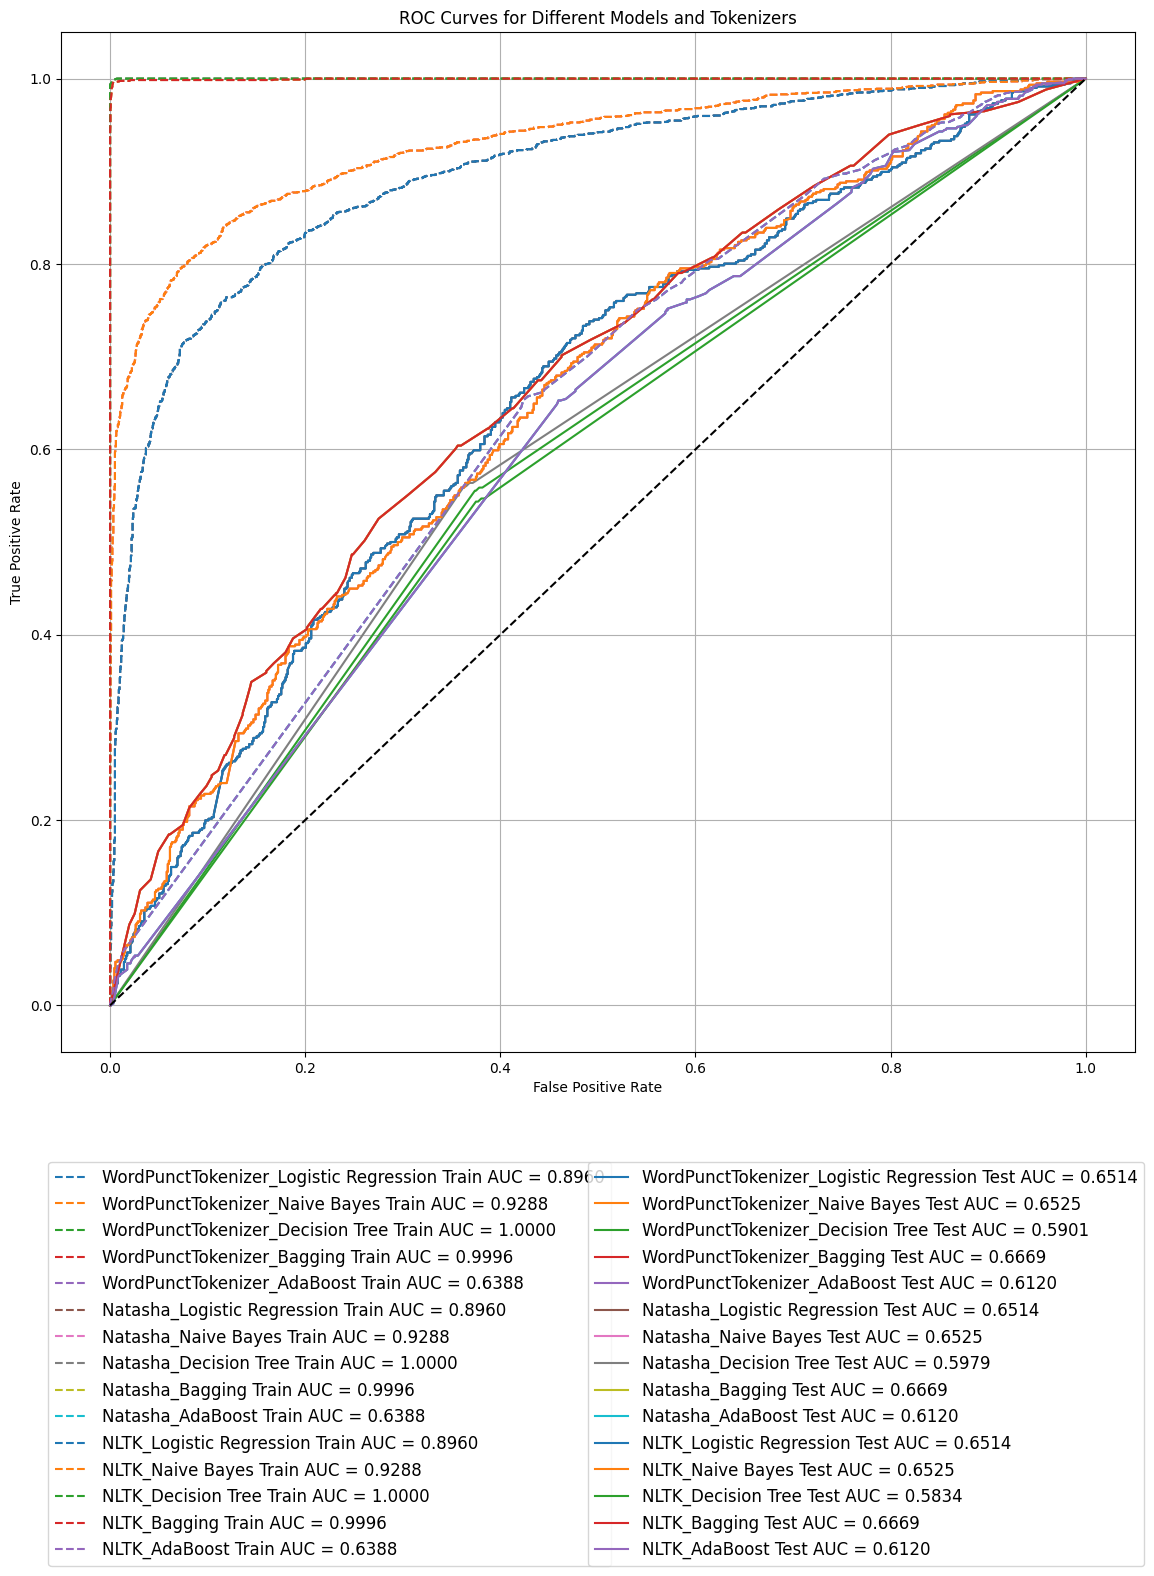

In [10]:
# Визуализация результатов
visualize_results(out_dict)
